### RCNN

**Network Model:**

This RCNN model has a hidden classification layer, a fully connected classification layer, hidden regression layer, and a fully connected regression layer.

The RESNET backbone has been unfrozen during training to get better results.

During training, the model acheives 88% accuracy.

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/computer\ vision/hw5
%ls

/content/drive/.shortcut-targets-by-id/1Gav1JPaiiUVP2HtU82fTVhfZn5MqgdM-/hw5
 eval_test1.json      eval_test3.json      hw5_data_2024@             loshaa_hw5_colab.ipynb
 eval_test1_out.txt   eval_test3_out.txt   hw5.pdf                    loshaa_hw5.ipynb
 eval_test2.json      eval_test4.json     'hw5_start(copy).ipynb'     model.pth
 eval_test2_out.txt   eval_test4_out.txt   hw5_start_version2.ipynb


In [34]:


import numpy as np
import json
from PIL import Image
from os.path import join

import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import models
import torchvision.transforms as transforms
import copy
import torch.nn.functional as F



In [35]:
from re import I
"""
Implement and test the utilities in support of evaluating the results
from the region-by-region decisions and turning them into detections.

All rectangles are four component lists (or tuples) giving the upper
left and lower right cornders of an axis-aligned rectangle.  For example,
[2, 9, 12, 18] has upper left corner (2,9) and lower right (12, 18)

The region predictions for an image for an image are stored in a list
of dictionaries, each giving the class, the activation and the
bounding rectangle.  For example,

{
    "class": 2,
    "a":  0.67,
    "rectangle": (18, 14, 50, 75)
}

if the class is 0 this means there is no detection and the rectangle
should be ignored.  The region predictions must be turned into the
detection results by filtering those with class 0 and through non
maximum supression.  The resulting regions should be considered the
"detections" for the image.

After this, detections should be compared to the ground truth

The ground truth regions for an image are stored as a list of dictionaries.
Each dictionary contains the region's class and bounding rectangle.
Here is an example dictionary:

{
    "class":  3,
    "rectangle": (15, 20, 56, 65)
}

Class 0 will not appear in the ground truth.
"""

def area(rect):
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w


def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """
    x0, y0, x1, y1 = rect1
    u0, v0, u1, v1 = rect2
    ir = (max(x0, u0), max(y0, v0), min(x1, u1), min(y1, v1))
    if ir[0] >= ir[2] or ir[1] >= ir[3]:
        return 0
    else:
        return area(ir) / (area(rect1) + area(rect2) - area(ir))


def predictions_to_detections(predictions, iou_threshold=0.5):
    """
    Input: List of region predictions

    Output: List of region predictions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and the non-maximum suppression
    applied.
    """
     # remove class label 0
    detections = [pred for pred in predictions if pred['class'] != 0]

    # order by activation
    detections = sorted(detections, key = lambda x: x['a'])

    # non max suppression
    result_detections = []
    while detections:
      max_d = detections[0]
      detections.pop(0)
      if not any(iou(d['rectangle'], max_d['rectangle']) >= iou_threshold and d["class"] == max_d["class"] for d in detections):
            result_detections.append(max_d)

    result_detections = sorted(result_detections, key = lambda x: x['a'], reverse=True)

    return result_detections


def evaluate(detections, gt_detections, iou_threshold=0.5):
    """
    Input:
    1. The detections returned by the predictions_to_detections function
    2. The list of ground truth regions, and
    3. The IOU threshold

    The calculation must compare each detection region to the ground
    truth detection regions to determine which are correct and which
    are incorrect.  Finally, it must compute the average precision for
    up to n detections.

    Returns:
    list of correct detections,
    list of incorrect detections,
    list of ground truth regions that are missed,
    AP@n value.
    """
    m = len(gt_detections)
    b = []
    correct_detections = []
    incorrect_detections = []
    for det in detections:
      g = None
      for gt in gt_detections:
        iou_val = iou(det['rectangle'], gt['rectangle'])
        if det['class'] == gt['class'] and iou_val > iou_threshold:
              g = gt
              break
      if g is None:
          b.append(0)
          incorrect_detections.append(det)
      else:
          b.append(1)
          correct_detections.append(det)
          gt_detections.remove(g)

    # Calculate AP value
    n = len(b)
    precision = np.cumsum(b) / (np.arange(n)+1)
    recall = np.cumsum(b) / m

    # Compute AP using precision-recall curve
    pr_pairs = list(zip(precision, recall))
    pj = []
    for j in range(11):
      rj = j/10
      max_pi = np.max([pi for pi, ri in pr_pairs if ri >= rj] or [0])
      pj.append(max_pi)
    ap = np.sum(pj) * 1/11

    return correct_detections, incorrect_detections, gt_detections, ap


In [36]:
def test_iou():
    """
    Use this function for you own testing of your IOU function
    """
    # should be .370
    rect1 = (0, 5, 11, 15)
    rect2 = (2, 9, 12, 18)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0
    rect1 = (2, -3, 11, 4)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

    # should be 0.2
    rect1 = (3, 12, 9, 15)
    res = iou(rect1, rect2)
    print(f"iou for {rect1} {rect2} is {res:1.2f}")

test_iou()

iou for (0, 5, 11, 15) (2, 9, 12, 18) is 0.37
iou for (2, -3, 11, 4) (2, 9, 12, 18) is 0.00
iou for (3, 12, 9, 15) (2, 9, 12, 18) is 0.20


In [37]:





def test_evaluation_code(in_json_file):
    with open(in_json_file, "r") as in_fp:
        data = json.load(in_fp)

    region_predictions = data["region_predictions"]
    gt_detections = data["gt_detections"]

    detections = predictions_to_detections(region_predictions)
    print(f"DETECTIONS: count = {len(detections)}")
    if len(detections) >= 2:
        print(f"DETECTIONS: first activation {detections[0]['a']:.2f}" )
        print(f"DETECTIONS: last activation {detections[-1]['a']:.2f}")
    elif len(detections) == 1:
        print(f"DETECTIONS: only activation {detections[0]['a']:.2f}")
    else:
        print(f"DETECTIONS: no activations")

    correct, incorrect, missed, ap = evaluate(detections, gt_detections)

    print(f"AP: num correct {len(correct)}")
    if len(correct) > 0:
        print(f"AP: first correct activation {correct[0]['a']:.2f}")

    print(f"AP: num incorrect {len(incorrect)}")
    if len(incorrect) > 0:
        print(f"AP: first incorrect activation {incorrect[0]['a']:.2f}")

    print(f"AP: num ground truth missed {len(missed)}")
    print(f"AP: final AP value {ap:1.3f}")


In [38]:
test_evaluation_code('eval_test1.json')

DETECTIONS: count = 2
DETECTIONS: first activation 0.90
DETECTIONS: last activation 0.70
AP: num correct 1
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.70
AP: num ground truth missed 2
AP: final AP value 0.364


In [39]:
test_evaluation_code('eval_test2.json')

DETECTIONS: count = 5
DETECTIONS: first activation 0.94
DETECTIONS: last activation 0.55
AP: num correct 4
AP: first correct activation 0.90
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.655


In [40]:
test_evaluation_code('eval_test3.json')

DETECTIONS: count = 1
DETECTIONS: only activation 0.94
AP: num correct 0
AP: num incorrect 1
AP: first incorrect activation 0.94
AP: num ground truth missed 1
AP: final AP value 0.000


In [41]:


test_evaluation_code('eval_test4.json')

DETECTIONS: count = 11
DETECTIONS: first activation 0.89
DETECTIONS: last activation 0.65
AP: num correct 10
AP: first correct activation 0.89
AP: num incorrect 1
AP: first incorrect activation 0.88
AP: num ground truth missed 1
AP: final AP value 0.835


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class RCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(RCNN, self).__init__()

        # Pretrained backbone
        resnet = models.resnet18(pretrained=True)

        # Remove the last fc layer of the pretrained network
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze backbone weights
        for param in self.backbone.parameters():
            # param.requires_grad = False
            param.requires_grad = True

        # Classification layers
        self.fc_classification_hidden = nn.Linear(resnet.fc.in_features, 20)
        self.fc_classification_output = nn.Linear(20, num_classes)

        # Regression layers
        self.fc_regression_hidden = nn.Linear(resnet.fc.in_features, 50)
        self.fc_regression_output = nn.Linear(50, num_classes * 4)

    def forward(self, x):
        # Feature extraction
        features = self.backbone(x)
        features = torch.flatten(features, 1)

        # Classification
        classification_hidden = F.relu(self.fc_classification_hidden(features))
        classification_output = self.fc_classification_output(
            classification_hidden)

        # Bounding box regression
        regression_hidden = F.relu(self.fc_regression_hidden(features))
        bbox_output = self.fc_regression_output(regression_hidden)
        bbox_output = bbox_output.view(-1, classification_output.size(1), 4)

        return classification_output, bbox_output

In [43]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]


# Dictionaries mapping class labels to names.
LABELS_TO_NAMES = {0: 'nothing',
                   1: 'bicycle',
                   2: 'car',
                   3: 'motorbike',
                   4: 'person',}


LABELS_TO_NAMES_LARGE = {0: 'nothing',
                         1: 'aeroplane',
                         2: 'bicycle',
                         3: 'bird',
                         4: 'boat',
                         5: 'bottle',
                         6: 'bus',
                         7: 'car',
                         8: 'cat',
                         9: 'chair',
                         10: 'cow',
                         11: 'diningtable',
                         12: 'dog',
                         13: 'horse',
                         14: 'motorbike',
                         15: 'person',
                         16: 'pottedplant',
                         17: 'sheep',
                         18: 'sofa',
                         19: 'train',
                         20: 'tvmonitor'}


class HW5Dataset(Dataset):
    '''
    Dataset for Train and Validation.
    Input:
        data_root - path to either the train or valid image directories
        json_file - path to either train.json or valid.json
    Output:
        candidate_region - 3 x M x M tensor
        ground_truth_bbox - 1 x 4 tensor
        ground_truth_class
    '''
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root
        self.candidate_region_size = candidate_region_size

        self.images = []
        self.candidate_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_bboxes = torch.empty((0, 4), dtype=int)
        self.ground_truth_classes = torch.empty(0, dtype=int)
        for key, values in data_dict.items():
            for val in values:
                self.images.append(key)
                self.candidate_bboxes = torch.cat((self.candidate_bboxes, torch.tensor(val['bbox']).unsqueeze(0)))
                self.ground_truth_bboxes = torch.cat((self.ground_truth_bboxes, torch.tensor(val['gt_bbox']).unsqueeze(0)))
                self.ground_truth_classes = torch.cat((self.ground_truth_classes, torch.tensor(val['class']).unsqueeze(0)))

        # Transform to convert to tensor, resize, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])

        image = Image.open(image_path)

        # Crop the image to the candidate region.
        candidate_bbox = self.candidate_bboxes[idx, :]
        candidate_region = image.crop((candidate_bbox[0].item(), candidate_bbox[1].item(), candidate_bbox[2].item(), candidate_bbox[3].item()))

        width, height = candidate_region.size
        x_scale = self.candidate_region_size / width
        y_scale = self.candidate_region_size / height

        # Transform to resize, convert to tensor, and normalize.
        candidate_region = self.transform(candidate_region)

        # Resize ground truth bounding box.
        gt_bbox = self.ground_truth_bboxes[idx, :]
        resized_gt_x0 = (gt_bbox[0] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y0 = (gt_bbox[1] - candidate_bbox[1]) * y_scale / self.candidate_region_size
        resized_gt_x1 = (gt_bbox[2] - candidate_bbox[0]) * x_scale / self.candidate_region_size
        resized_gt_y1 = (gt_bbox[3] - candidate_bbox[1]) * y_scale / self.candidate_region_size

        resized_gt_bbox = torch.tensor([resized_gt_x0, resized_gt_y0, resized_gt_x1, resized_gt_y1])

        return candidate_region, resized_gt_bbox, self.ground_truth_classes[idx]


class HW5DatasetTest(Dataset):
    """
    Dataset for Test.
    Input:
        data_root - path to the test image directory
        json_file - path to test.json
    Returns:
        image - numpy array A x B x 3 (RGB)
        candidate_regions - NUM_CANDIDATE_REGIONS x 3 x M x M tensor
        candidate_bboxes - all candidate bounding boxes for an image
        ground_truth_bboxes - all ground truth bounding boxes for an image
        ground_truth_classes - all ground truth classes for an image
    """
    def __init__(self, data_root, json_file, candidate_region_size=224):
        with open(json_file, 'r') as f:
            data_dict = json.load(f)

        self.data_root = data_root

        self.images = []
        self.candidate_bboxes = []
        self.ground_truth_bboxes = []
        self.ground_truth_classes = []
        for key, values in data_dict.items():
            self.images.append(key)

            bboxes = torch.empty((len(values['candidate_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['candidate_bboxes']):
                bboxes[i, :] = torch.tensor(bbox)
            self.candidate_bboxes.append(bboxes)

            labels = torch.empty((len(values['gt_bboxes'])), dtype=int)
            bboxes = torch.empty((len(values['gt_bboxes']), 4), dtype=int)
            for i, bbox in enumerate(values['gt_bboxes']):
                bboxes[i, :] = torch.tensor(bbox['bbox'])
                labels[i] = bbox['class']
            self.ground_truth_bboxes.append(bboxes)
            self.ground_truth_classes.append(labels)

        self.candidate_region_size = candidate_region_size

        # Transform to resize, convert to tensor, and normalize.
        self.transform = transforms.Compose([transforms.Resize((candidate_region_size, candidate_region_size)),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image.
        image_path = join(self.data_root, self.images[idx])
        image = Image.open(image_path)

        # Apply transform to resize and normalize the candidate images.
        idx_candidate_bboxes = self.candidate_bboxes[idx]
        candidate_regions = torch.empty((len(idx_candidate_bboxes), 3, self.candidate_region_size, self.candidate_region_size))
        for i, bbox in enumerate(idx_candidate_bboxes):
            candidate_region = image.crop((bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()))
            candidate_region = self.transform(candidate_region)
            candidate_regions[i] = candidate_region

        return np.array(image), candidate_regions, self.candidate_bboxes[idx], self.ground_truth_bboxes[idx], self.ground_truth_classes[idx]


In [44]:
def get_accuracy(rcnn, valid_loader, device):
    correct = 0
    total = 0
    val_loss = []
    all_valid_predicted = []
    all_valid_labels = []
    with torch.no_grad():
        for candidate_region, resized_gt_bbox, ground_truth_class in valid_loader:
            candidate_region = candidate_region.to(device)
            resized_gt_bbox = resized_gt_bbox.to(device)
            ground_truth_class = ground_truth_class.to(device)

            pred_class, pred_bbox = rcnn(candidate_region)
            _, predicted = torch.max(pred_class.data, 1)

            all_valid_predicted.extend(predicted.cpu().detach().numpy())
            all_valid_labels.extend(ground_truth_class.cpu().detach().numpy())

            selected_pred_bbox = pred_bbox[torch.arange(len(ground_truth_class)), ground_truth_class]
            selected_resized_gt_bbox = resized_gt_bbox[torch.arange(len(ground_truth_class))]
            selected_pred_bbox = selected_pred_bbox[ground_truth_class != 0]
            selected_resized_gt_bbox = selected_resized_gt_bbox[ground_truth_class != 0]

            val_classification_loss = criterion(pred_class, ground_truth_class)
            val_regression_loss = F.mse_loss(selected_pred_bbox, selected_resized_gt_bbox)
            val_combined_loss = val_classification_loss + val_regression_loss
            if torch.isnan(val_regression_loss.cpu()):
                val_combined_loss = val_classification_loss
            val_loss.append(val_combined_loss.item())

            total += ground_truth_class.size(0)
            correct += (predicted == ground_truth_class).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy on validation set: {accuracy} %')
    return accuracy, np.mean(val_loss), all_valid_predicted, all_valid_labels


In [45]:

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim


data_path = "hw5_data_2024"
num_classes = len(LABELS_TO_NAMES)
print(num_classes, "labels")

# Init Model
rcnn = RCNN()
criterion = nn.CrossEntropyLoss()
mseloss = nn.MSELoss()
optimizer = optim.SGD(rcnn.parameters(), lr=0.001, momentum=0.9)

train_ds = HW5Dataset(data_root=data_path+"/train", json_file=data_path+"/train.json")
valid_ds = HW5Dataset(data_root=data_path+"/valid", json_file=data_path+"/valid.json")
test_ds = HW5DatasetTest(data_root=data_path+"/test", json_file=data_path+"/test.json")

model_path = './model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\ndevice:",device)
rcnn.to(device)
optimizer = torch.optim.SGD(rcnn.parameters(), lr=0.001)
batch_size = 16


5 labels


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



device: cuda


In [46]:
def compute_confusion_matrix(test_pairs, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for t in test_pairs:
        confusion_matrix[t[0]][t[1]] += 1
    return confusion_matrix

In [47]:
def get_coords(bbox, candidate_box, xmax, ymax):
  w = candidate_box[2] - candidate_box[0]
  h = candidate_box[3] - candidate_box[1]
  x = candidate_box[0]
  y = candidate_box[1]
  return torch.stack([torch.clip(bbox[0] * w + x, 0, xmax), torch.clip(bbox[1] * h + y, 0, ymax), torch.clip(bbox[2] * w + x, 0, xmax), torch.clip(bbox[3] * h + y, 0, ymax)]).to(torch.int)

Training

train_loader size: 1479
Loss at: 0: 1.13
Loss at: 1000: 0.65
Accuracy on validation set: 78 %
Saving Model... New best model found. Epoch: 1, Training Loss: 3.01, Validation Accuracy: 78.00%
Epoch 1 Loss: 0.002
Loss at: 0: 0.40
Loss at: 1000: 0.27
Accuracy on validation set: 83 %
Saving Model... New best model found. Epoch: 2, Training Loss: 0.52, Validation Accuracy: 83.00%
Epoch 2 Loss: 0.000
Loss at: 0: 0.36
Loss at: 1000: 0.12
Accuracy on validation set: 84 %
Saving Model... New best model found. Epoch: 3, Training Loss: 3.62, Validation Accuracy: 84.00%
Epoch 3 Loss: 0.002
Loss at: 0: 0.31
Loss at: 1000: 0.26
Accuracy on validation set: 84 %
Epoch 4 Loss: 0.003
Loss at: 0: 0.09
Loss at: 1000: 0.18
Accuracy on validation set: 85 %
Saving Model... New best model found. Epoch: 5, Training Loss: 0.82, Validation Accuracy: 85.00%
Epoch 5 Loss: 0.001
Done training
Best model found at epoch 5 with validation accuracy of 85.00%

Confusion matrix for training
 0: 45595 1348 2061 1217 4422


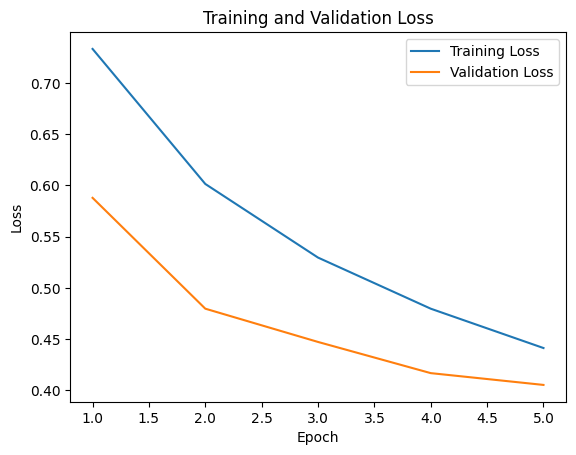

In [49]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Train Model
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=2)

print("train_loader size:", len(train_loader))
best_accuracy = -1
best_epoch = 0

total_iou = 0
total_correct = 0

train_losses = []
train_avg_losses = []
validation_losses = []

all_train_predicted = []
all_valid_predicted = []
all_train_labels = []
all_valid_labels = []

num_epochs = 5
# num_epochs = 1
# num_epochs = 10
for epoch in range(num_epochs):
    loss = 0.0
    for i, (candidate_region, resized_gt_bbox, ground_truth_class) in enumerate(train_loader):
        optimizer.zero_grad()

        candidate_region = candidate_region.to(device)
        resized_gt_bbox = resized_gt_bbox.to(device)
        ground_truth_class = ground_truth_class.to(device)

        pred_class, pred_bbox = rcnn(candidate_region)


        selected_pred_bbox = pred_bbox[ground_truth_class != 0, ground_truth_class[ground_truth_class != 0]]
        selected_resized_gt_bbox = resized_gt_bbox[torch.arange(len(ground_truth_class))]
        selected_resized_gt_bbox = selected_resized_gt_bbox[ground_truth_class != 0]


        # Calculate the combined loss
        classification_loss = criterion(pred_class, ground_truth_class)
        regression_loss = mseloss(selected_pred_bbox, selected_resized_gt_bbox)

        # Backpropagation
        if not torch.isnan(regression_loss):
          regression_loss.backward(retain_graph=True)
          loss = regression_loss.item()
        classification_loss.backward(retain_graph=True)
        loss = classification_loss.item()

        train_losses.append(loss)

        optimizer.step()


        _, pred = torch.max(pred_class.data, 1)
        all_train_predicted.extend(pred.cpu().detach().numpy())
        all_train_labels.extend(ground_truth_class.cpu().detach().numpy())

        # Avg iou
        for idx, p in enumerate(selected_pred_bbox):
            pred_bbox_rec = p.cpu().detach().numpy().tolist()
            resized_gt_bbox_rec = resized_gt_bbox[idx].cpu().detach().numpy().tolist()
            total_iou += iou(pred_bbox_rec, resized_gt_bbox_rec)
        total_correct += len(selected_pred_bbox)

        if i%1000==0:
          print(f'Loss at: {i}: {(loss):.2f}')





    accuracy, val_loss, valid_predicted, valid_labels = get_accuracy(rcnn, valid_loader, device)
    all_valid_predicted.extend(valid_predicted)
    all_valid_labels.extend(valid_labels)

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_epoch = epoch
      # Save the state of the best model
      torch.save(rcnn.state_dict(), model_path)

      print(f'Saving Model... New best model found. Epoch: {epoch+1}, Training Loss: {loss:.2f}, Validation Accuracy: {accuracy:.2f}%')

    train_avg_losses.append(np.mean(train_losses))
    validation_losses.append(val_loss)

    # Loss for the epoch
    print(f'Epoch {epoch + 1} Loss: {loss / len(train_loader):.3f}')

print("Done training")
print(f'Best model found at epoch {best_epoch+1} with validation accuracy of {best_accuracy:.2f}%')



# Confusion matrix
train_pairs = list(zip(all_train_predicted, all_train_labels))
cm = compute_confusion_matrix(train_pairs, num_classes)
print(f'\nConfusion matrix for training')
for i in range(num_classes):
    print(f'{i:2d}:', end='')
    for j in range(num_classes):
        print(f' {cm[i, j]:2d}', end='')
    print()
print()

valid_pairs = list(zip(all_valid_predicted, all_valid_labels))
cm = compute_confusion_matrix(valid_pairs, num_classes)
print(f'\nConfusion matrix for validation')
for i in range(num_classes):
    print(f'{i:2d}:', end='')
    for j in range(num_classes):
        print(f' {cm[i, j]:2d}', end='')
    print()

print("Class Labels:", LABELS_TO_NAMES)





# Average IOU
avg_iou = total_iou / total_correct if total_correct > 0 else 0.0
print(f'\nAvg iou: {avg_iou:.2f}\n')


# Plotting training and validation losses
print(train_avg_losses)
print(validation_losses)
plt.plot(range(1, num_epochs + 1), train_avg_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [28]:
# Load the saved model
rcnn = RCNN()
rcnn.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
rcnn.eval()

RCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [50]:
import cv2

RED = (255, 0, 0)
GREEN = (0, 255, 0)
YELLOW = (255, 255, 0)

def display_bbox(image, correct, incorrect, missed):
    image_np = np.array(image)

    for box in correct:
      box_rec = box["rectangle"]
      box_class = box["class"]
      color = GREEN
      x1, y1, x2, y2 = map(int, box_rec)
      cv2.rectangle(image_np, (x1, y1), (x2, y2), color, 2)
      cv2.putText(image_np, LABELS_TO_NAMES[box_class], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    for box in incorrect:
      box_rec = box["rectangle"]
      box_class = box["class"]
      color = RED
      x1, y1, x2, y2 = map(int, box_rec)
      cv2.rectangle(image_np, (x1, y1), (x2, y2), color, 2)
      cv2.putText(image_np, LABELS_TO_NAMES[box_class], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    for box in missed:
      box_rec = box["rectangle"]
      box_class = box["class"]
      color = YELLOW
      x1, y1, x2, y2 = map(int, box_rec)
      cv2.rectangle(image_np, (x1, y1), (x2, y2), color, 2)
      cv2.putText(image_np, LABELS_TO_NAMES[box_class], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

Testing

Class Labels: {0: 'nothing', 1: 'bicycle', 2: 'car', 3: 'motorbike', 4: 'person'}
test_loader size: 403
device: cuda


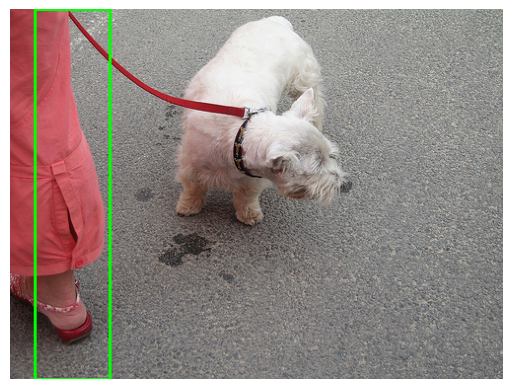

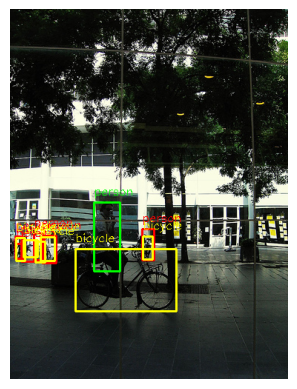

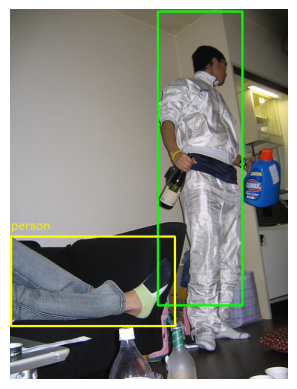

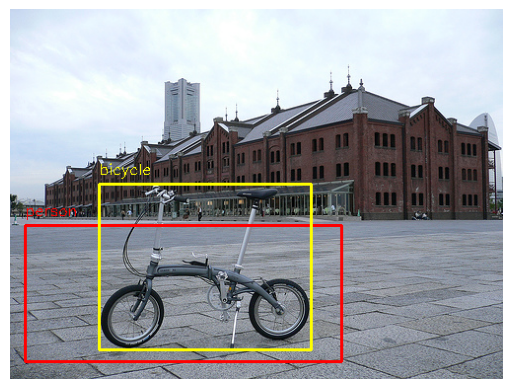

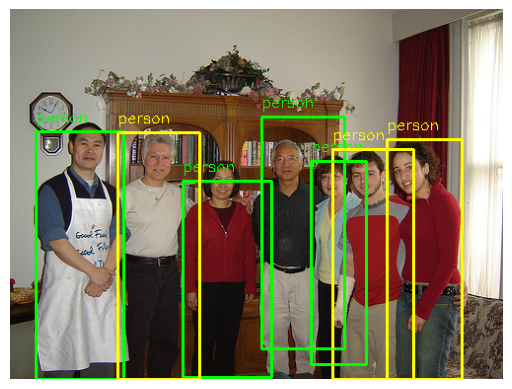

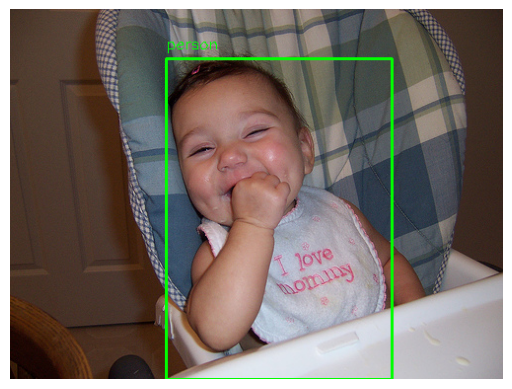

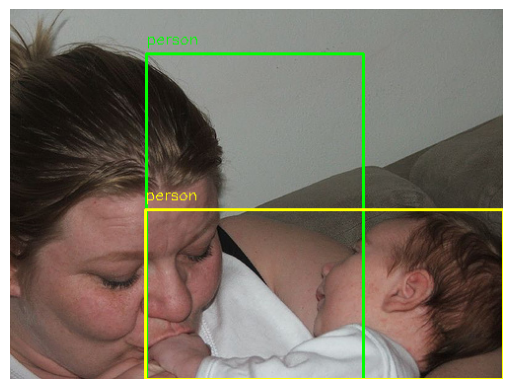

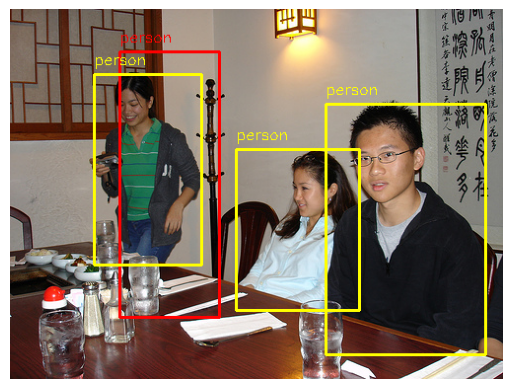

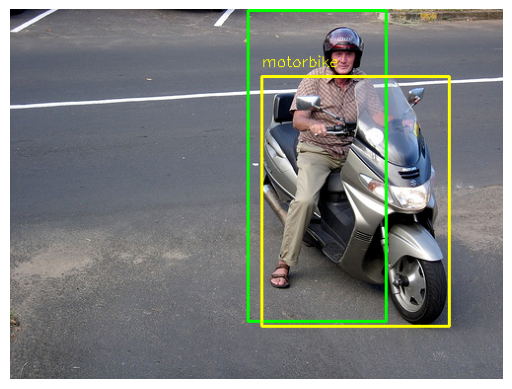

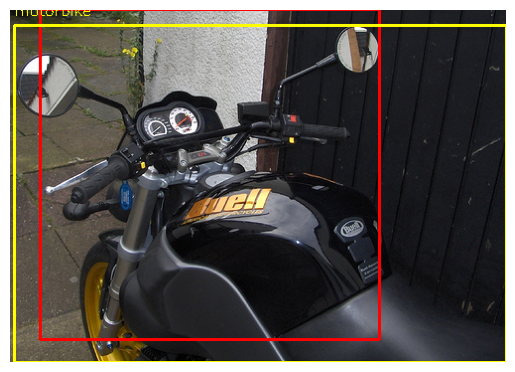

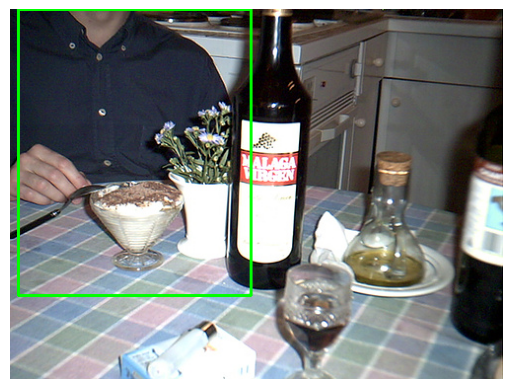

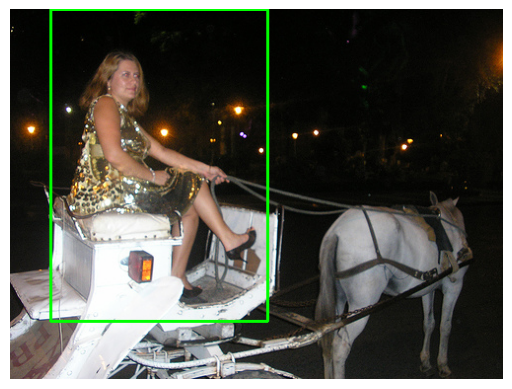

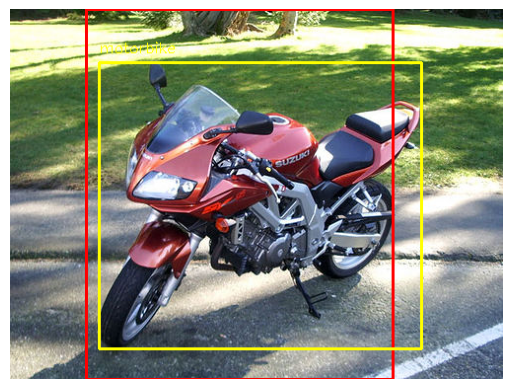

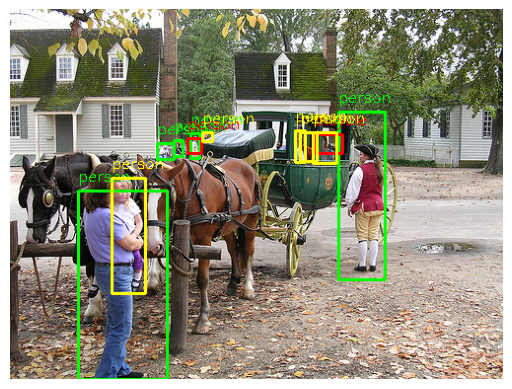

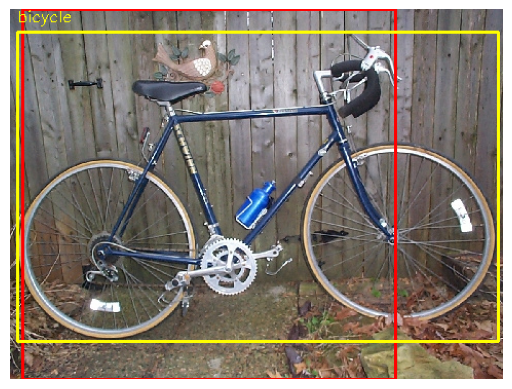

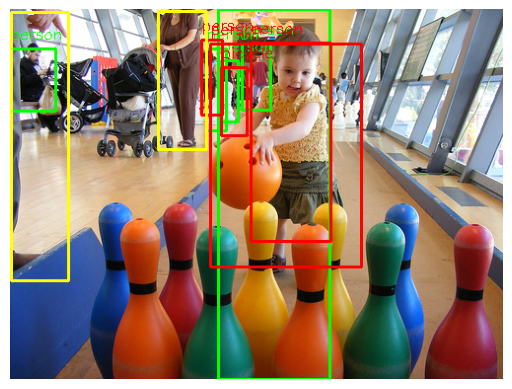

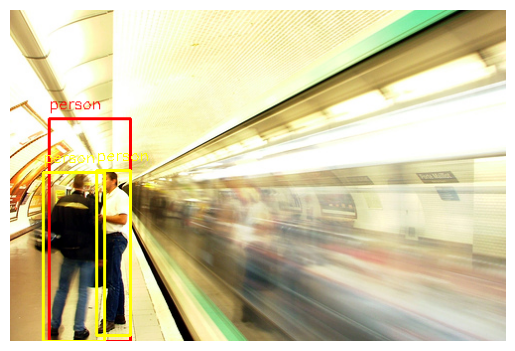


mAP: 0.47237305705047583

Class person: TP: 38.98%, Recall: 34.19%
Class car: TP: 2.88%, Recall: 12.14%
Class motorbike: TP: 0.32%, Recall: 5.19%
Class bicycle: TP: 0.48%, Recall: 5.83%


In [51]:
from torch.utils.data import DataLoader

# Testing

print("Class Labels:", LABELS_TO_NAMES)

test_loader = DataLoader(test_ds, shuffle=True)

print("test_loader size:", len(test_loader))

accuracy = 0

total_count = 0

print("device:", device)

rcnn.to(device)

mAP = 0.0
num_images = 0


class_tp = {}
class_recall = {}
total_gt = 0

for i, (image, candidate_regions, candidate_bboxes, ground_truth_bboxes, ground_truth_classes) in enumerate(test_loader):
    num_images += 1

    num_candidate_regions = candidate_regions.shape[1]
    candidate_regions = candidate_regions.to(device)
    ground_truth_classes = ground_truth_classes.to(device)

    pred_class, pred_bbox = rcnn(candidate_regions[0])

    pred_class_idx = torch.argmax(pred_class.data, 1)

    max_size = max(len(pred_class_idx), len(ground_truth_classes[0]))
    padded_pred_class_idx = F.pad(pred_class_idx, (0, max_size - len(pred_class_idx)), value=-1)
    padded_ground_truth_classes = F.pad(ground_truth_classes[0], (0, max_size - len(ground_truth_classes[0])), value=-1)
    accuracy += (padded_pred_class_idx == padded_ground_truth_classes).sum().item()

    total_count += num_candidate_regions

    selected_pred_bbox = []
    for i in range(len(pred_class_idx)):
        selected_pred_bbox.append(get_coords(pred_bbox[i, pred_class_idx[i], :], candidate_bboxes[0][i], image.shape[2], image.shape[1]))
    if len(selected_pred_bbox) > 0:
      selected_pred_bbox = torch.stack(selected_pred_bbox)
      selected_pred_bbox = selected_pred_bbox.cpu().numpy()


    # Create predictions  dictionary
    region_predictions = []
    for j in range(len(pred_class_idx)):
      if pred_class_idx[j] != 0:
        prediction_dic = {
                'class': pred_class_idx[j].item(),
                'a': pred_class[0, pred_class_idx[j].item()].item(),
                'rectangle': selected_pred_bbox[j],
            }
        region_predictions.append(prediction_dic)
    detections = predictions_to_detections(region_predictions)
    bbox = [d["rectangle"] for d in detections]
    detected_class_idx =  [i["class"] for i in detections]

    # Create ground truth dictionary
    ground_truth_regions = []
    for index in range(len(ground_truth_classes[0])):
        value = {
            "class": ground_truth_classes[0][index].item(),
            "rectangle": ground_truth_bboxes[0][index].cpu().detach().numpy().tolist()
        }
        ground_truth_regions.append(value)
    total_gt += len(ground_truth_regions)

    # Calc AP value
    correct_detections, incorrect_detections, missed_detections, AP = evaluate(detections, ground_truth_regions, 0.5)
    mAP += AP
    if i + 1 in [1, 16, 28, 30, 39, 75, 78, 88, 93, 146]:
      display_bbox(image[0], correct_detections, incorrect_detections, missed_detections)

    # Percent true positives
    for detection in correct_detections:
        cls = detection["class"]
        if cls not in class_tp:
            class_tp[cls] = 0
        class_tp[cls] += 1

    # Percent recall
    for detection in missed_detections:
        cls = detection["class"]
        if cls not in class_recall:
            class_recall[cls] = 0
        class_recall[cls] += 1




mAP /= num_images
print()
print(f"mAP: {mAP}\n")


for cls in class_tp.keys():
    print(f"Class {LABELS_TO_NAMES[cls]}: TP: {(100 * class_tp[cls]/total_gt):.2f}%, Recall: {(100 * class_recall[cls]/total_gt):.2f}%")


**Results Assessment:**

After adding a hidden layer for the classification and the regression, the model was able to detect the objects much more accuractly.

From the results, the model is best at detecting the person and the car class.

According to the confusion matrix, the person and car classes also get confused the most times. This is probably because the data has the most examples of person and car objects.

The model has a mAP value of 0.4 which is relativley high for this task.

Visually the model looks good too because the detections bound the objects well when they are detected.